In [2]:
from urllib.request import urlopen
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [2]:
time_position = []
latitude      = []
longitude     = []

end_time = time.time() + 60 * 60 # End time is set for current time + 60 * 60 (60 mints=3600 seconds which is one hour)
while time.time() < end_time:
    #This loop runs for 1 hour and extracts the time in seconds and 
    #latitude and longitude coordinates of the satellite provided by NASA
    with urlopen("http://api.open-notify.org/iss-now.json") as response:
        body = response.read()
    co_ordinates = json.loads(body.decode('utf-8'))  #converts bytes format to dictionary format
    longitude.append(co_ordinates['iss_position']['longitude']) # appends longitude value 
    latitude.append(co_ordinates['iss_position']['latitude'])   # appends latitude value
    time_position.append(co_ordinates['timestamp'])             # appends timestamp value

In [108]:
#creating the dataframe from the values of time, latitude and longitude
satellite_data = pd.DataFrame(list(zip(time_position,latitude,longitude)),columns = ['time','latitude','longitude'])

In [109]:
satellite_data.tail()

,time,latitude,longitude
7133,1681032298,-20.9390,-46.8187
7134,1681032298,-20.9149,-46.7978
7135,1681032298,-20.9149,-46.7978
7136,1681032300,-20.8425,-46.7353
7137,1681032300,-20.8184,-46.7145


It can be observed from the above data that time is not in the interval of 5 seconds. Hence, we must extract the rows for every 5 seconds of time values.

In [110]:
time_interval_5 = []
a = list(satellite_data['time'])[0]
time_interval_5.append(a)
for i in list(satellite_data['time']):
    # This loop runs through every time value in satellite data from second to last value 
    # This checks with the previous time value and if the difference between them is >=5
    # then appends the time value to list time_interval_5 
    # Note - We might not find value at exact interval of 5 seconds 
    # therefore considering time difference value of greater than 5 which can be 6 at times.
    if i-a>=5 :
        time_interval_5.append(i)
        a = i
    else:
        continue

In [111]:
#filtering the data with the time values with an time interval of 5 seconds 
satellite_data_5seconds = satellite_data[satellite_data.time.isin(time_interval_5)].groupby('time').head(1)

In [112]:
# converting the string datatype to numeric datatypes for latitude and longitude columns
satellite_data_5seconds["latitude"] = pd.to_numeric(satellite_data_5seconds["latitude"])
satellite_data_5seconds["longitude"] = pd.to_numeric(satellite_data_5seconds["longitude"])

In [113]:
#printing last 5 records of dataframe
satellite_data_5seconds.tail()

,time,latitude,longitude
7097,1681032280,-21.8054,-47.5746
7107,1681032285,-21.5651,-47.3636
7117,1681032290,-21.3246,-47.1534
7127,1681032295,-21.0837,-46.9440
7136,1681032300,-20.8425,-46.7353


Here, it can be observed that the time values are having the difference of 5 seconds.

In [114]:
#saving the dataframe to a pickle file
satellite_data_5seconds.to_pickle('satellite_data_5seconds.pkl')

In [3]:
#loading the pickle data
satellite_data_5seconds = pd.read_pickle('satellite_data_5seconds.pkl')

In [4]:
#converting the latitude and longitude values to Points 
geometry = [Point(xy) for xy in zip(satellite_data_5seconds['longitude'], satellite_data_5seconds['latitude'])]
gdf = GeoDataFrame(satellite_data_5seconds, geometry=geometry) 

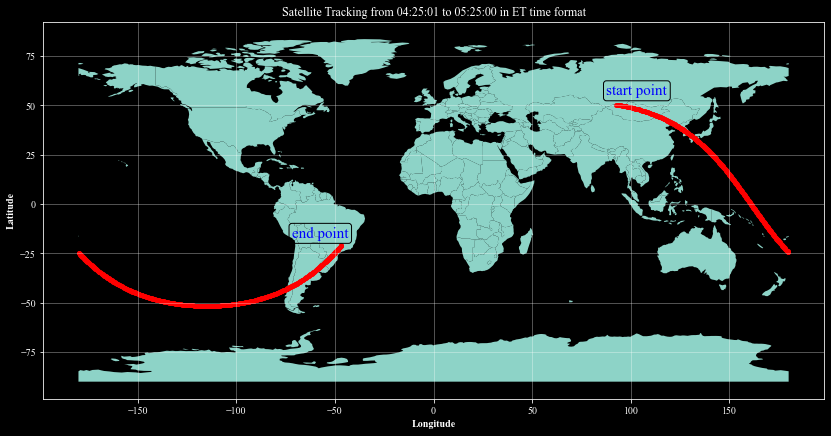

In [41]:
plt.style.use('dark_background')
plt.rcParams["font.family"] = "Times New Roman"

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gax   = gdf.plot(ax=world.plot(figsize=(14, 8)), marker='o', color='red', markersize=15)

start = time.strftime('%H:%M:%S', time.gmtime(list(satellite_data_5seconds['time'])[0]-4*3600)) # start time
end   = time.strftime('%H:%M:%S', time.gmtime(list(satellite_data_5seconds['time'])[-1]-4*3600))# end time 

start_x,start_y = satellite_data_5seconds['longitude'].tolist()[0],satellite_data_5seconds['latitude'].tolist()[0]
end_x,end_y     = satellite_data_5seconds['longitude'].tolist()[-1],satellite_data_5seconds['latitude'].tolist()[-1]

plt.text(x=start_x-5,y=start_y+5,s='start point',fontsize=15,color='blue',
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2'))
plt.text(x=end_x-25,y=end_y+4,s='end point',fontsize=15,color='blue',
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2'))

plt.title('Satellite Tracking from '+start+' to '+end+' in ET time format')
plt.xlabel('Longitude',fontweight='bold')
plt.ylabel('Latitude',fontweight='bold')
plt.grid(True,alpha=0.4)
plt.show()